In [1]:
from keras.models import Sequential, load_model
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil
%matplotlib inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
model = custom_unet(input_shape=(512,512,1))
model.load_weights('my_model.h5')

In [3]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')


def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

In [4]:
def gather_images(data_path):
    images = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if '_K' in f:
        continue
      else:
        images.append(f)
        #segmentations.append(f.replace('.nii', '_K.nii'))

    #print(images[0], segmentations[0])
    images = np.array(images)
    #segmentations = np.array(segmentations)

    indices = np.array(range(len(images))) # we will use this in the next step.

    return images

In [5]:
def read_nifti_file(path):
    nifti_image = nib.load(path)
    nib_data = nifti_image.get_fdata()
    return nib_data

def retrieve_images_for_prediction(data_path, images,num, size=(512,512)):
  x = []
  for i in range(num):
    img = read_nifti_file(data_path+'\\'+images[i])
    img = resize(img,(size[0], size[1], img.shape[-1]))
    for j in range(img.shape[-1]):
      x.append(img[:,:,j])
  x = np.array(x)[:,:,:,np.newaxis]

  return x

In [6]:
data_path = r'C:\Users\UAB\data\512_AllNII'
images = gather_images(data_path)

In [7]:
print(images[0])
print(len(images))

101934_1_96_L_M.nii
248


In [8]:
prediction_set = retrieve_images_for_prediction(data_path, images, 5, size=(512,512))

In [9]:
print(prediction_set.shape)

(480, 512, 512, 1)


In [10]:
def visualise_data_pred(x):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(10,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    #contours = measure.find_contours(y[50*i,:,:,0], .99)
    #for contour in contours:
      #ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')

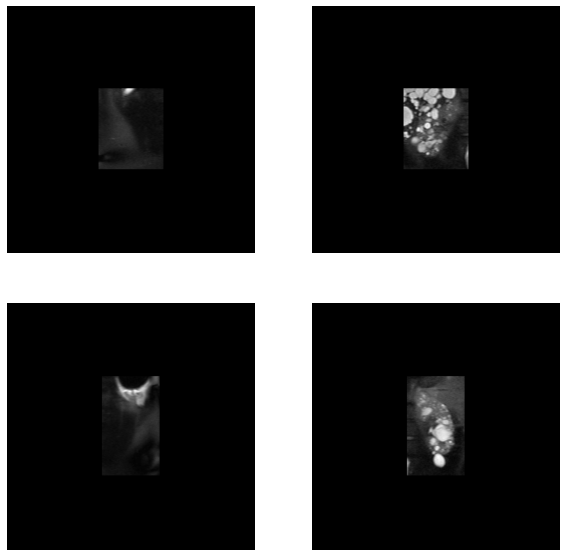

In [11]:
visualise_data_pred(prediction_set)

In [12]:
MR_K_predictions = model.predict(prediction_set)
MR_K_predictions = MR_K_predictions.astype('float')

In [13]:
def visualise_data(x, y):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    ax.axis('off')

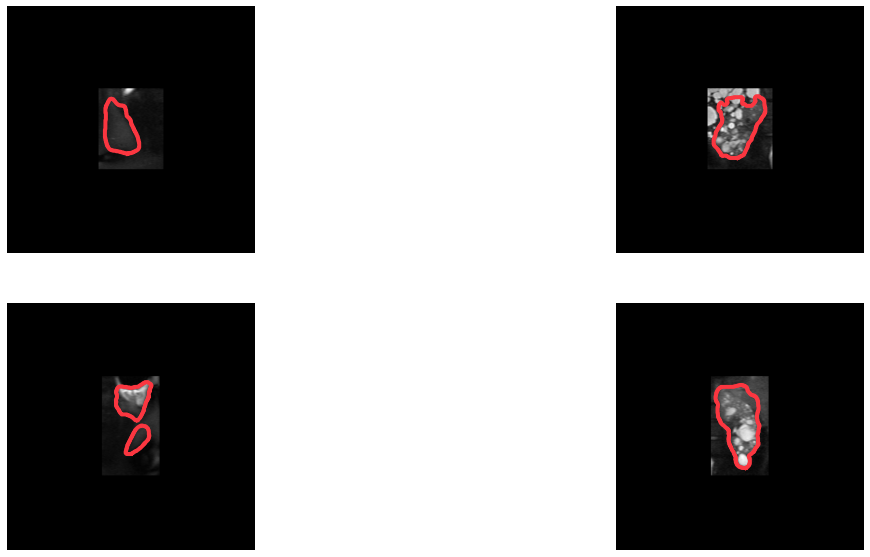

In [14]:
visualise_data(prediction_set, MR_K_predictions)

In [15]:
model = custom_unet(input_shape=(512,512,1))
model.load_weights('model_75E_100I.h5')
MR_K_predictions_75 = model.predict(prediction_set)
MR_K_predictions_75 = MR_K_predictions.astype('float')

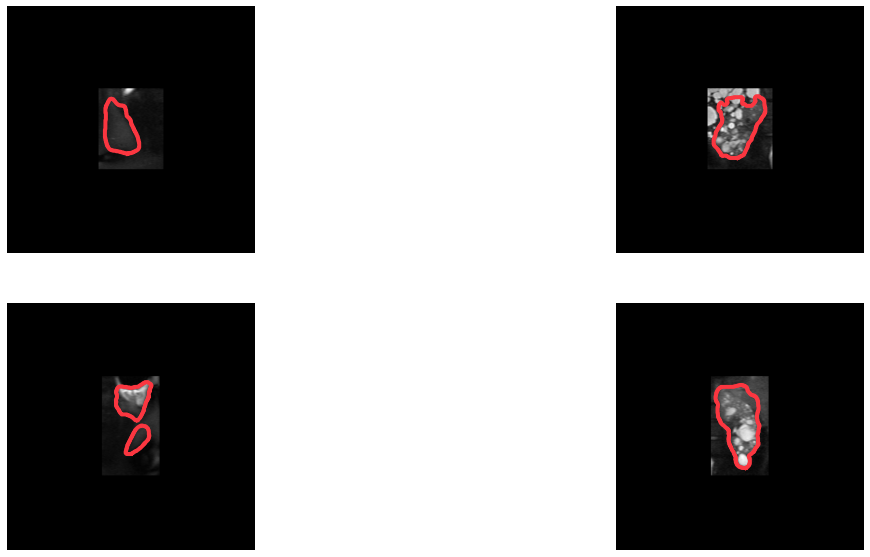

In [16]:
visualise_data(prediction_set, MR_K_predictions_75)

In [133]:
image_og = nib.load(data_path+'\\'+images[1])
image_og = image_og.get_fdata()

In [134]:
print(image_og.shape[-1])

96


In [135]:
orig_filename = images[1]
orig_clip_fname = orig_filename[:-4]
print(orig_clip_fname)

101934_1_96_R_M


In [136]:
new_fname = '%s_P50_3.nii' %orig_clip_fname
print(new_fname)

101934_1_96_R_M_P50_3.nii


In [137]:
final_path = r'C:\Users\UAB\data\512_AllNII\Kidney Predict 50 epoch'
affine = np.eye(4)
new_set = np.zeros((512,512,96))
test_data = MR_K_predictions[97:193,:,:,0]
for i in range(test_data.shape[0]):
    new_set[:,:,i] = test_data[i,:,:]

In [138]:
nifti_file = nib.Nifti1Image(new_set, affine)
nib.save(nifti_file, os.path.join(final_path, "%s" %new_fname))

In [19]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [20]:
segmentations = gather_set(data_path, '_K')
path = r'C:\Users\UAB\data\512_AllNII\Kidney Predict 50 epoch'
predictions = gather_set(path, '_P50_3')

In [21]:
image_set = retrieve_images_for_prediction(data_path, images, 2, size=(512,512))
seg_set = retrieve_images_for_prediction(data_path, segmentations, 2, size=(512,512))
prediction_set = retrieve_images_for_prediction(path, predictions, 2, size=(512,512))

In [22]:
print(image_set.shape, seg_set.shape, prediction_set.shape)

(192, 512, 512, 1) (192, 512, 512, 1) (192, 512, 512, 1)


In [23]:
print(images[0], segmentations[0],predictions[0])

101934_1_96_L_M.nii 101934_1_96_L_M_K.nii 101934_1_96_L_M_P50_3.nii


In [24]:
def visualise_data_and_prediction(x, y, y_pred):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#FB3640', lw=4)
    contours = measure.find_contours(y_pred[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#35A7FF', lw=4)
    ax.axis('off')

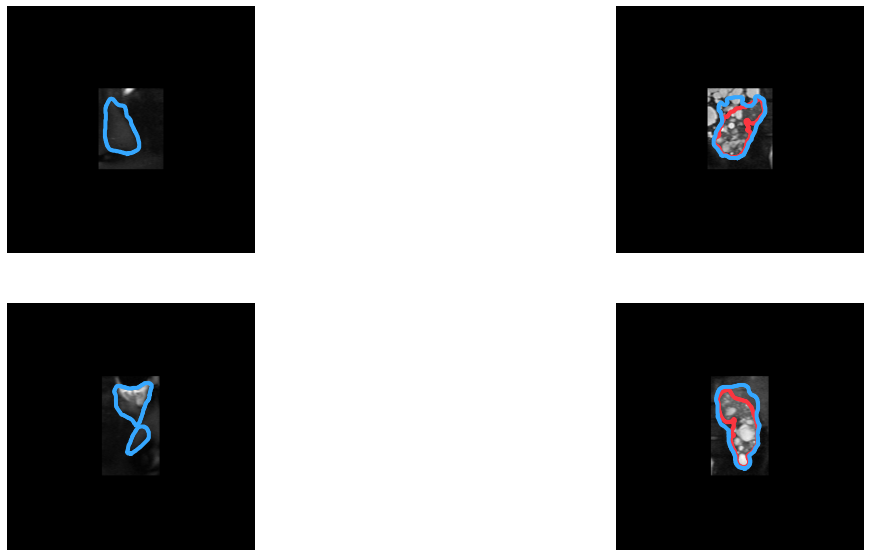

In [25]:
visualise_data_and_prediction(image_set, seg_set, prediction_set)

In [26]:
def visualise_data_and_multi_prediction(x, y, y1, y2):
  n=4
  dim = int(np.ceil(np.sqrt(n)))
  fig = plt.figure(figsize=(20,10))
  for i in range(n):
    ax = fig.add_subplot(dim, dim, i+1)
    ax.imshow(x[50*i,:,:,0], cmap='gray')
    contours = measure.find_contours(y[50*i,:,:,0], .99)
    for j,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#32f06b', lw=4)#truth color
    contours = measure.find_contours(y1[50*i,:,:,0], .99)
    for k,contour in enumerate(contours):
      ax.plot(contour[:,1], contour[:,0], color='#f03ee4', lw=4)
    contours = measure.find_contours(y2[50*i,:,:,0], .99)
    for contour in contours:
      ax.plot(contour[:,1], contour[:,0], color='#f03ee4', lw=4)#prediction color
    ax.axis('off')

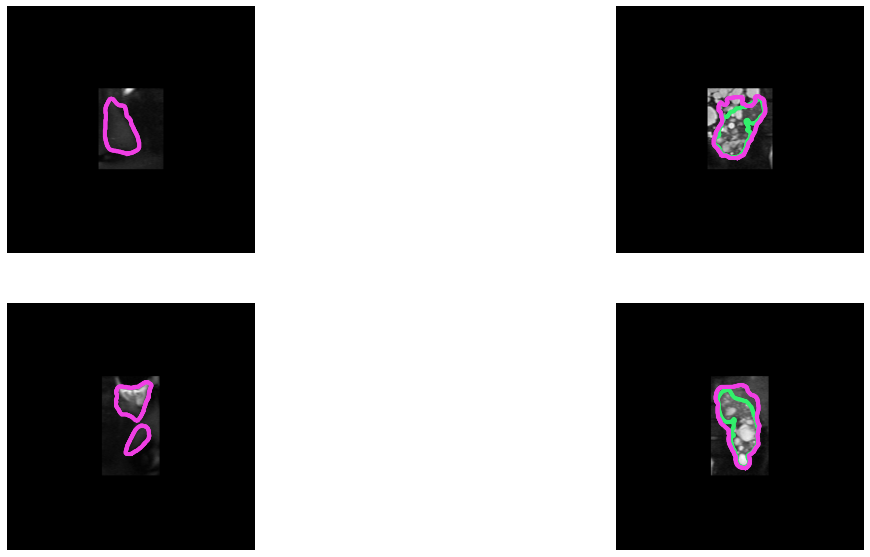

In [27]:
visualise_data_and_multi_prediction(image_set, seg_set, MR_K_predictions,MR_K_predictions_75)

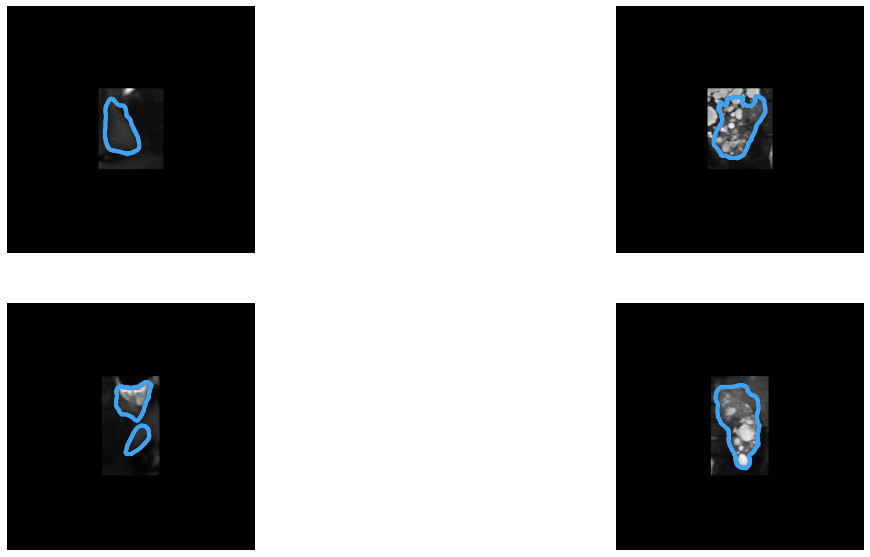

In [28]:
visualise_data_and_prediction(image_set, MR_K_predictions_75, MR_K_predictions)